In [25]:
# Import des Librairies

import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import re
import numpy as np
from numpy.random import multinomial
from scipy.special import digamma
from scipy.stats import dirichlet
import gensim.corpora as corpora
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pprint import pprint
import gensim
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
from sparsebm import generate_LBM_dataset, ModelSelection, LBM
from sparsebm.utils import reorder_rows, reorder_cols, ARI, CARI
from scipy.sparse import coo_matrix
from collections import Counter

## Stopwords

In [26]:
# Stopwords : mots à ne pas considérer
try :
    stopwords = stopwords.words('english')
except :
    nltk.download('stopwords')
    stopwords = stopwords.words('english')

# append new stopwords

with open('stopwords-en.txt', 'r') as f:
    for line in f:
        stopwords.append(line.strip())

## Preprocessing du Dataframe

In [27]:
# Load du dataframe des Reviews d'Amazon : formattage pour ressembler aux mieux au donnée du papier

df = pd.read_csv('Reviews.csv')
df.drop(['Id', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary'], axis=1, inplace=True)

# Considération des produits avec plus de 50 reviews et des utilisateurs avec plus de 20 reviews

prod = (df['ProductId'].value_counts() > 50)
prod = prod[prod].index.tolist()

user = (df['UserId'].value_counts() > 20)
user = user[user].index.tolist()

df = df[df['ProductId'].isin(prod)]
df = df[df['UserId'].isin(user)]

# On garde les mots avec plus de 3 lettres et plus de 10 occurences

def remove_short_words(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) >= 3]
    return ' '.join(filtered_words)

def remove_punctuation_and_numbers(text):
    translator = str.maketrans('', '', string.punctuation + string.digits)
    return text.translate(translator)


df['Text'] = df['Text']\
        .apply(lambda x: x.lower())\
        .apply(remove_punctuation_and_numbers)\
        .apply(remove_short_words)\
        .apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))\
        .apply(lambda x: x.split(' '))

words = Counter()

for idx in df.index:
    words.update(df.loc[idx, 'Text'])

words = {k:v for k, v in words.items() if v >= 10}

df['Text'] = df['Text'].apply(lambda x: [word for word in x if word in words])

df.drop_duplicates(subset=['UserId', 'ProductId'], inplace=True)

## Visualisation des mots avec WordCloud

In [28]:
# Wordcloud pour visualisation (enregistrement sous 'wordcloud.png')

a = df['Text'].apply(lambda x: ' '.join(x))# Import the wordcloud library
# Join the different processed titles together.
long_string = ','.join(a)

wordcloud = WordCloud(width= 1000, height = 600, max_words=100,
                      random_state=1, background_color='gray', colormap='viridis_r',
                      collocations=False).generate(long_string)

wordcloud.to_file('wordcloud.png')

/Users/samy/anaconda3/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


## Création des matrices, déclaration des constantes, et du modèle LDA

In [32]:
# Creation de la matrice d'incidence : 0 partout sauf là ou il y a une intercation ie review 1

load_A = True

if load_A:
    A = pd.read_csv('A.csv', index_col=0)
else:
    A = pd.DataFrame(np.zeros((len(df['UserId'].unique()), len(df['ProductId'].unique()))))
    A.index = df['UserId'].unique()
    A.columns = df['ProductId'].unique()

    for idx in df.index:
        A.loc[df.loc[idx, 'UserId'], df.loc[idx, 'ProductId']] = 1

In [34]:
# Déclaration des constantes

M = A.shape[0] # number of users
P = A.shape[1] # number of products
V = len(words) # vocabulary size
K = 12 # number of topics
Q = 12 # qte cluster row
L = 14 # qte cluster column
D=np.ones(A.shape) # for amazon dataset, D is a matrix of ones (il y a une review par un user pour un produit donné)

# Initialisation du paramètre alpha déclaré comme valant 1 pour chaque topic
alphas = np.ones(K)

In [35]:
# Création du corpus pour la LDA

id2word = corpora.Dictionary(df['Text'])

texts = df['Text']

corpus = [id2word.doc2bow(text) for text in texts]

In [36]:
# Construction du modèle LDA

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=K)

# Affichages des 10 mots principaux pour chaque topic

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.025*"taste" + 0.025*"coffee" + 0.024*"tea" + 0.015*"water" + '
  '0.012*"flavor" + 0.009*"drink" + 0.006*"sweet" + 0.006*"cup" + '
  '0.006*"chips" + 0.006*"love"'),
 (1,
  '0.031*"coffee" + 0.026*"tea" + 0.019*"flavor" + 0.013*"taste" + '
  '0.009*"water" + 0.007*"drink" + 0.007*"nice" + 0.006*"product" + '
  '0.006*"strong" + 0.006*"flavored"'),
 (2,
  '0.014*"flavor" + 0.011*"hair" + 0.008*"dog" + 0.008*"taste" + 0.007*"time" '
  '+ 0.007*"water" + 0.007*"bit" + 0.007*"food" + 0.006*"product" + '
  '0.006*"tea"'),
 (3,
  '0.022*"tea" + 0.019*"chocolate" + 0.013*"taste" + 0.008*"flavor" + '
  '0.008*"product" + 0.007*"cookies" + 0.007*"love" + 0.006*"sweet" + '
  '0.006*"sugar" + 0.006*"snack"'),
 (4,
  '0.019*"taste" + 0.014*"chips" + 0.012*"product" + 0.010*"love" + '
  '0.010*"flavor" + 0.007*"salt" + 0.007*"sugar" + 0.007*"bag" + 0.007*"drink" '
  '+ 0.006*"chocolate"'),
 (5,
  '0.012*"product" + 0.008*"food" + 0.008*"treats" + 0.007*"cookies" + '
  '0.007*"dogs" + 0.00

In [37]:
# Visualisation des topics

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(K))
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(K) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.061470  0.058369       1        1  13.077908
11    -0.109245 -0.002878       2        1  11.495624
0     -0.047543  0.001720       3        1  11.493904
3      0.005763  0.010090       4        1   9.450047
4      0.011009 -0.022126       5        1   9.417642
1     -0.067953 -0.011292       6        1   9.192604
2      0.005626  0.020494       7        1   8.058952
6      0.024987 -0.029002       8        1   7.416870
10    -0.023577  0.052680       9        1   5.878575
7      0.078489 -0.057668      10        1   5.113311
5      0.078967  0.016588      11        1   4.916459
8     -0.017993 -0.036975      12        1   4.488104, topic_info=        Term          Freq         Total Category  logprob  loglift
602   coffee  18541.000000  18541.000000  Default  30.0000  30.0000
537      tea  14620.000000  14620.000000  Default  29.0000  29.0000
81      food  10071.000000  10071.000000  Default  28.0000  28.0000
0      chips   7401.000000   7401.000000  Default  27.0000  27.0000
2006    hair   2706.000000   2706.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
0      chips    215.520857   7401.063347  Topic12  -5.5796  -0.4326
418    water    209.377035   8313.064461  Topic12  -5.6085  -0.5777
27      size    176.832257   2567.205448  Topic12  -5.7774   0.4284
376      eat    181.074437   5132.470260  Topic12  -5.7537  -0.2407
23       bit    178.319731   4893.428713  Topic12  -5.7690  -0.2083

[1018 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2914      7  0.075823  acknowledging
2914     12  0.834049  acknowledging
451       1  0.088372            add
451       2  0.127689            add
451       3  0.139592            add
...     ...       ...            ...
2969      8  0.016207          zukes
2969      9  0.005402          zukes
2969     10  0.216098          zukes
2969     11  0.464611          zukes
2969     12  0.021610          zukes

[4744 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 12, 1, 4, 5, 2, 3, 7, 11, 8, 6, 9])

In [38]:
# T est la matrice de même taille que A mais où Aij=1, Tij=k avec k 
# le topic principal de la review de l'utilisateur i sur le produit j

T = pd.DataFrame(np.zeros((len(df['UserId'].unique()),len(df['ProductId'].unique()))))
T.index = df['UserId'].unique()
T.columns = df['ProductId'].unique()

for idx in df.index:
    bow = id2word.doc2bow(df.loc[idx, 'Text'])
    topic = max(lda_model.get_document_topics(bow), key=lambda x: x[1])[0]
    T.loc[df.loc[idx, 'UserId'], df.loc[idx, 'ProductId']] = topic+1

### Problème avec l'initialisation du clustering spectral car définition des matrices de similarité trop lourde

In [18]:
#### Ne pas run cette partie, beaucoup trop long ####

# Sy représente la matrice de similarité entre les utilisateurs : 
# Sy = qté de topic de review similaire sur des mêmes produits entre 2 users : ils commentent de la même façon

Sy= np.zeros((M, M))

for i in range(M):
    for iprime in range(M):
        for j in range(P):
            if T.iloc[i, j] == T.iloc[iprime, j]:
                Sy[i, iprime] += A.iloc[i, j] * A.iloc[iprime, j]



# Sx représente la matrice de similarité entre les produits : 
# Sx = qté de topic de review similaire sur des mêmes users entre 2 produits :  ils ont le même genre de topic

Sx = np.zeros((P, P))

for i in range(P):
    for iprime in range(P):
        for j in range(M):
            if T.iloc[j, i] == T.iloc[j, iprime]:
                Sx[i, iprime] += A.iloc[j, i] * A.iloc[j, iprime]

### A défaut, on utilise la méthode de co-clustering par le Latent Block Model

---------- START RANDOM INITIALIZATIONS ---------- 
100 of 100 Initializations:  [100% ] |#############| [ Elapsed Time: 0:00:33 ] 
----- CONTINUE TRAINING FOR THE BEST INITIALIZATIONS ----- 
1 of 1 Runs:  [100% ] |############################| [ Elapsed Time: 0:00:01 ] 


Text(0.5, 1.0, 'Reordered Matrix')

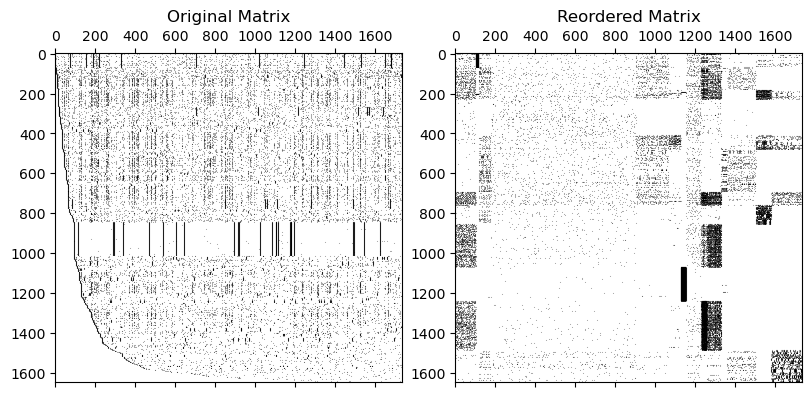

In [39]:
# Initialisation du premier LBM pour la clusterisation initial 
# (pas spectral car pb d'opitmisation du code des matrices de similarité)

lbm_model_selection = LBM(
    Q,
    L,
    n_init_total_run=1
)

lbm_models = lbm_model_selection.fit(np.matrix(A))

# Reordonnement des lignes et colonnes en fonction du clustering des indiv et variables (sans le texte)

reconstructed_matrix = coo_matrix(np.matrix(A).copy())
reorder_rows(reconstructed_matrix, np.argsort(lbm_models.row_labels))
reorder_cols(reconstructed_matrix, np.argsort(lbm_models.column_labels))

# Create the plot
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)

# Plotting the original matrix

ax1.spy(A, markersize=0.05, marker="*", c="black")
ax1.set_title("Original Matrix")

ax2.spy(reconstructed_matrix, markersize=0.05, marker="*", c="black")
ax2.set_title("Reordered Matrix")

In [40]:
#  Définition de la matrice Y : Y is a matrix of size len(df['UserId'].unique()) * Q) 
#  where the (i, j)th entry is 1 if the ith product belongs to the jth cluster

Y = np.zeros((len(df['UserId'].unique()), Q))
for i in range(len(df['UserId'].unique())):
    for j in range(Q):
        if lbm_models.row_labels[i] == j:
            Y[i, j] = 1

# Définition de la matrice X : X is a matrix of size len(df['UserId'].unique()) * L) 
# where the (i, j)th entry is 1 if the ith user belongs to the jth cluster

X = np.zeros((len(df['ProductId'].unique()), L))
for i in range(len(df['ProductId'].unique())):
    for j in range(L):
        if lbm_models.column_labels[i] == j:
            X[i, j] = 1

In [41]:
# A_full : Copy the DataFrame A avec plus d'informations
A_full = A.copy()

# The last column is the cluster of the individual users
A_full['cluster_row'] = lbm_models.row_labels.tolist()

# # The last row is the cluster of the individual products
A_full.loc[len(A_full)] = lbm_models.column_labels.tolist() + [np.nan]
A_full.index = list(A_full.index[:-1]) + ['cluster_column']

In [42]:
# N is the matrix where the (i, j)th entry is the len of the Text of the ith user for the jth product
# Create mappings for UserId and ProductId to contiguous indices
user_id_mapping = {user_id: idx for idx, user_id in enumerate(df['UserId'].unique())}
product_id_mapping = {product_id: idx for idx, product_id in enumerate(df['ProductId'].unique())}

# Initialize the matrix N
N = np.zeros((len(user_id_mapping), len(product_id_mapping)))

# Populate the matrix
for idx in df.index:
    user_idx = user_id_mapping[df.loc[idx, 'UserId']]
    product_idx = product_id_mapping[df.loc[idx, 'ProductId']]
    N[user_idx, product_idx] = len(df.loc[idx, 'Text'])


In [48]:
load_A_full_topic = True

if load_A_full_topic:
    A_full_topic = pd.read_csv('A_full_topic.csv', index_col=0)

else:

    A_full_topic = A_full.copy()

    for i in A_full_topic.index[:-1]:
        for j in A_full_topic.columns[:-1]:
            if A_full_topic.loc[i, j] == 1:
                txt = df.loc[(df['UserId'] == i) & (df['ProductId'] == j), 'Text']
                txt = txt.values[0]
                topic = lda_model.get_document_topics(id2word.doc2bow(txt))[0][0]
            else:
                topic = -1
            A_full_topic.loc[i, j] = str(topic)

    # Save the matrix A_full_topic because it takes a long time to compute
    A_full_topic.to_csv('A_full_topic.csv')

# 4m20 to run if load_A_full_topic = False

In [50]:
# Theta_ql is the topic proportion of the lth cluster of the qth row

# Initialize Theta_ql
Theta_ql = np.zeros((Q, L, K))

# Populate Theta_ql
for i in A_full_topic.index[:-1]:
    for j in A_full_topic.columns[:-1]:   
        if A_full_topic.loc[i, j] != '-1':
            Theta_ql[int(A_full_topic.loc[i, 'cluster_row']), int(A_full_topic.loc['cluster_column', j]), int(A_full_topic.loc[i, j])] += 1  

# Normalize Theta_ql
for q in range(Q):
    for l in range(L):
        if np.sum(Theta_ql[q, l, :]) != 0:
            Theta_ql[q, l, :] /= np.sum(Theta_ql[q, l, :])

In [46]:
def get_topic_n_word(i,j,n):
    txt = df.loc[(df['UserId'] == j) & (df['ProductId'] == i), 'Text']
    txt = txt.values[0][n]
    id_word = id2word.token2id[txt]
    topic = lda_model.get_term_topics(id_word)
    try:
        max_topic = max(topic, key=lambda x: x[1])
        max_topic = max_topic[0]
    except:
        max_topic = np.random.randint(0, K) # if the word is not in the vocabulary, we assign it to a random topic
    return max_topic



# p(Aij = 1 | XiqYjl=1) = PIql^Aij * (1 - PIql)^(1 - Aij)

def p_Aij_XY(Aij, PIql):
    prob = PIql**Aij * (1 - PIql)**(1 - Aij)
    return prob

# p(A | Y, X, PI) = prod_{i, j} p(Aij | Yi, Xj, PI)

def p_A_YX(A, Y, X, PI):
    prob = 1
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            for q in range(Y.shape[1]):
                for l in range(X.shape[1]):
                    prob *= p_Aij_XY(A.iloc[i, j], PI.iloc[q, l])**(Y.iloc[i, q] * X.iloc[j, l])
    return prob


def phi_ijdnk(i, j, d, n, k, w, gamma, Y, X):
    first_prod = 1
    second_prod = 1
    for v in range(V):
        first_prod*=beta_kv(k, v, A, w, D, N, w, gamma, Y, X)**w[i, j, d, n, v]
    for q in range(Q):
        for l in range(L):
            second_prod *= np.exp(digamma(gamma[q][l][k]) - digamma(sum(gamma[q][l])))**(Y[i, q]*X[j, l])
    return first_prod*second_prod


def gamma_qlk(q, l, k, alpha, A, Y, X, D, N, b, w, gamma):
    res = alpha[k]
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    res += A[i][j]*Y[i, q]*X[j, l]*phi_ijdnk(i, j, d, n, k, w, gamma, Y, X)
    return res

def beta_kv(k, v, A, W, D, N, w, gamma, Y, X):
    res=0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    res+=A[i][j]*W[i][j][d][n][v]*phi_ijdnk(i, j, d, n, k, w, gamma, Y, X)

def pi_ql(q, l, A, Y, X):  # GOOD
    res=0
    A = A.reset_index(drop=True)
    A.columns = range(A.shape[1])
    shape_A = A.shape
    A = np.matrix(A)
    for i in range(shape_A[0]):
        for j in range(shape_A[1]):
            res+=Y[i, q]*X[j, l]*A[i,j]
    return res


def p_q(q, Y):  # GOOD
    return np.sum(Y[:,q])

def s(l, X): # GOOD
    return np.sum(X[:,l])

def q_theta(theta, Q, L, alpha, A, Y, X, D, N, b, w, gamma):
    prod=1
    for q in range(Q):
        for l in range(L):
            gammas = [gamma_qlk(q, l, k, alpha, A, Y, X, D, N, b, w, gamma) for k in range(K)]
            prod*=dirichlet.pdf(theta[q, l], alpha=gammas)   
    return prod

def q_z(z, i, j, d, n, b, w, gamma, Y, X):
    phi = [phi_ijdnk(i, j, d, n, k, b, w, gamma, Y, X) for k in range(K)]
    return multinomial.pdf(z[i][j][d][n], n=1, p=phi)

def greedy_serch(Y, X):
    for i in range(A.shape[0]):
        q = np.where(Y[i]==1)[0][0]
        friends = False
        for i_prime in range(A.shape[0]):

            if Y[i_prime, q] == 1 and i_prime != i:
                friends = True
                break
        if friends:
            Final_Clust = q
            bestGain = 0
            for q_prime in range(Q):
                if q_prime != q:
                    Y[i, q] = 0
                    Y[i, q_prime] = 1
                    gain = compute_gain(Y, X, D, N, A, w, gamma, Q, L, K)
                    if gain > bestGain:
                        bestGain = gain
                        Final_Clust = q_prime
            Y[i, q] = 0
            Y[i, Final_Clust] = 1

    for j in range(A.shape[1]):
        l = X[j].idxmax()
        friends = False
        for j_prime in range(A.shape[1]) and j_prime != j:
            if X[j_prime, l] == 1:
                friends = True
                break
        if friends:
            Final_Clust = l
            bestGain = 0
            for l_prime in range(L):
                if l_prime != l:
                    X[j, l] = 0
                    X[j, l_prime] = 1
                    gain = compute_gain(Y, X, D, N, A, w, gamma, Q, L, K)
                    if gain > bestGain:
                        bestGain = gain
                        Final_Clust = l_prime
            X[j, l] = 0
            X[j, Final_Clust] = 1
    return Y, X

def compute_gain(Y, X, D, N, A, w, gamma, Q, L, K):
    gain1 = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            a = A[i, j]
            subres = 0
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    for q in range(Q):
                        for l in range(L):
                            subsubres = 0
                            for k in range(K):
                                subsubres += phi_ijdnk(i, j, d, n, k, w, gamma, Y, X)*(digamma(gamma[q][l][k]) - digamma(sum(gamma[q][l])))
                            subres += X[j, l]*subsubres
            gain1 += a*subres
    gain2 = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            a = A[i, j]
            subres = 0
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    for q in range(Q):
                        for l in range(L):
                            subsubres = 0
                            for k in range(K):
                                subsubres += phi_ijdnk(i, j, d, n, k, w, gamma, Y, X)*(digamma(gamma[q][l][k]) - digamma(sum(gamma[q][l])))
                            subres += Y[i,q]*subsubres
            gain2 += a*subres

    return gain1 + gain2

def lower_bound(A, W, D, N, w, gamma, Y, X, alpha, b):

    res0 = 0
    for i in range(M):
        for j in range(P):
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    for k in range(K):
                        for v in range(V):
                            res0 += W[i][j][d][n][v] * \
                                np.log(beta_kv(k, v, A, W, D, N, w, gamma, Y, X))
                        res0 *= phi_ijdnk(i, j, d, n, k, w, gamma, Y, X)
            res0 *= A[i][j]

    res1 = 0
    for i in range(M):
        for j in range(P):
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    for q in range(Q):
                        for l in range(L):
                            for k in range(K):
                                res1 += phi_ijdnk(i, j, d, n, k, w, gamma, Y, X)*(
                                    digamma(gamma[q][l][k]) - digamma(sum(gamma[q][l])))
                            res1 *= Y[i][q]*X[j][l]
            res1 *= A[i][j]

    res2 = 0
    for q in range(Q):
        for l in range(L):
            res2 += (np.log(gamma(sum(alphas))) - sum(np.log(gamma(alphas))) +
                     sum([(alphas[k]-1)*(digamma(gamma[q][l][k]) - digamma(sum(gamma[q][l])))]))

    res3 = 0
    for i in range(M):
        for j in range(P):
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    for k in range(K):
                        res3 += phi_ijdnk(i, j, d, n, k, w, gamma, Y, X) * \
                            np.log(phi_ijdnk(i, j, d, n, k, w, gamma, Y, X))
            res3 *= A[i][j]

    res4 = 0
    for q in range(Q):
        for l in range(L):
            res4 += (np.log(gamma(sum(gamma[q][l]))) - sum(np.log(gamma(gamma[q][l][k]))) + sum(
                [(gamma[q][l][k]-1)*(digamma(gamma[q][l][k]) - digamma(sum(gamma[q][l])))]))

    return res0 + res1 + res2 - res3 - res4

In [ ]:
max_iter = 10
i=0
while i<max_iter:
    Y, X = greedy_serch(Y, X)
    i+=1